In [11]:
import logging
import torch
import dgl
import random
import numpy as np
from dataloader import DataLoaderHGNN
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.decomposition import PCA

from numpy import dot
from numpy.linalg import norm

/home/hieunt/anaconda3/envs/cfil/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
emb_file = open('data/douban_movie/embedding/user.embedding_64')
text = emb_file.read()
lines = text.split("\n")

user_embedding = {}
for line in lines:
    words = line.split()
    if len(words) == 0:
        continue
    words[0] = str(int(words[0]) - 24228 + 1)
    user_embedding[words[0]] = []
    for i in range(1, len(words)):
        user_embedding[words[0]].append(float(words[i]))

In [3]:
emb_file = open('data/douban_movie/embedding/item.embedding_64')
text = emb_file.read()
lines = text.split("\n")

movie_embedding = {}
for line in lines:
    words = line.split()
    if len(words) == 0:
        continue
    words[0] = str(int(words[0]) + 1) 
    
    movie_embedding[words[0]] = []
    for i in range(1, len(words)):
        movie_embedding[words[0]].append(float(words[i]))


In [4]:
def cosine_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

def pairwise_euclid(target, group):
    cosines = []
    for item in group:
        cosines.append(euclidean(movie_embedding[target], movie_embedding[item]))
    return sum(cosines) / len(cosines)

def pairwise_cosine(target, group):
    cosines = []
    for item in group:
        cosines.append(cosine_sim(movie_embedding[target], movie_embedding[item]))
    return sum(cosines) / len(cosines)


def user_movie_euclid(user, movie_group):
    cosines = []
    for item in movie_group:
        cosines.append(euclidean(user_embedding[user], movie_embedding[item]))
    return sum(cosines) / len(cosines)

def user_movie_cosine(user, movie_group):
    cosines = []
    for item in movie_group:
        cosines.append(cosine_sim(user_embedding[user], movie_embedding[item]))
    return sum(cosines) / len(cosines)

In [5]:
print(f'Number of movies : { len(movie_embedding.keys()) }' )
print(f'Number of users : { len(user_embedding.keys()) }' )

Number of movies : 12677
Number of users : 13367


In [6]:
def read_file(filepath):
    f = open(filepath)
    text = f.read()
    lines = text.split("\n")
    del lines[-1]

    dic = {}
    rev_dic = {}
    for line in lines:
        words = line.split()
        if words[0] not in dic.keys():
            dic[words[0]] = []
        if words[1] not in rev_dic.keys():
            rev_dic[words[1]] = []
        
        dic[words[0]].append(words[1])
        rev_dic[words[1]].append(words[0])
    return dic, rev_dic

In [4]:
movie_actor, actor_movie = read_file("data/douban_movie/movie_actor.dat")
movie_director, director_movie = read_file("data/douban_movie/movie_director.dat")
movie_type, type_movie = read_file("data/douban_movie/movie_type.dat")


In [203]:
len(actor_movie), len(director_movie), len(type_movie)

(6311, 2449, 38)

In [51]:
f = open("data/douban_movie/user_movie.dat")
text = f.read()
lines = text.split("\n")
del lines[-1]


user_rating = {}
user_movie = {}
user_movie_liked = {}
user_movie_hated = {}
movie_user = {}
movie_user_like = {}
movie_user_hate = {}
for line in lines:
    words = line.split("\t")
    liked = False
    if int(words[2]) >= 4:
        liked = True 
    
    if words[0] not in user_rating.keys():
        user_rating[words[0]] = [0, 0]
    if words[0] not in user_movie.keys():
        user_movie[words[0]] = []
    
    if words[0] not in user_movie_hated.keys():
        user_movie_hated[words[0]] = []
    
    if words[0] not in user_movie_liked.keys():
        user_movie_liked[words[0]] = []
    if words[1] not in movie_user.keys():
        movie_user[words[1]] = []
    if words[1] not in movie_user_like.keys():
        movie_user_like[words[1]] = []
    if words[1] not in movie_user_hate.keys():
        movie_user_hate[words[1]] = []
    
    movie_user[words[1]].append(words[0])
    user_movie[words[0]].append(words[1])
    if liked:
        user_rating[words[0]][1] += 1
        user_movie_liked[words[0]].append(words[1])
        movie_user_like[words[1]].append(words[0])
    else:
        user_rating[words[0]][0] += 1
        user_movie_hated[words[0]].append(words[1])
        movie_user_hate[words[1]].append(words[0])

In [8]:
movies = []
movies_id = []
for k, v in movie_user.items():
    movies.append(len(v))
    movies_id.append(k)

movies_liked = []
for k, v in movie_user_like.items():
    movies_liked.append(len(v))

movies_hated = []
for k, v in movie_user_hate.items():
    movies_hated.append(len(v))

In [91]:
with open('foo_all.tsv', 'w') as of, open('foo_all_meta.tsv', 'w') as metaof:
    user_emb = user_embedding['9885']
    s = ''
    for x in user_emb:
        s += str(x)
        s += '\t'
    of.write(s)
    of.write('\n')
    metaof.write('User\n')

    for u in user_movie_liked['9885']:
        emb = movie_embedding[u]
        s = ''
        for x in emb:
            s += str(x)
            s += '\t'
        of.write(s)
        of.write('\n')
        metaof.write('Movie Liked\n')
    
    for u in user_movie_hated['9885']:
        emb = movie_embedding[u]
        s = ''
        for x in emb:
            s += str(x)
            s += '\t'
        of.write(s)
        of.write('\n')
        metaof.write('Movie Hated\n')


In [14]:
all_movie = list(movie_embedding.keys())
for m in mid:
    all_movie.remove(m)

In [60]:
pd_new = pd.concat([data_df[data_df['label'] == 'User'], data_df[data_df['label'] == 'Other Movies']])
index = pd_new.index.values.tolist()

In [62]:
pd_new = pd.concat([data_df[data_df['label'] == 'User no watch top 100'], data_df[data_df['label'] == 'Other Movies']])
index = pd_new.index.values.tolist()

In [55]:
X = data_df[list(np.arange(64))]

pca = PCA(n_components=2)
components = pca.fit_transform(X)



In [57]:
fig = px.scatter(components, x=0, y=1, color=data_df['label'])
fig.update_traces(
    opacity=0.8
)
fig.show()

In [63]:
fig = px.scatter(components[index], x=0, y=1, color=pd_new['label'])
fig.show()

In [27]:
components.shape

(26044, 2)

In [53]:
data = []

labels = list(np.arange(64))
labels += ['label']
for m in mid:
    movie_emb = movie_embedding[m]    
    data.append(movie_emb + ['Popular Movies'])
    
for m in all_movie:
    movie_emb = movie_embedding[m]    
    data.append(movie_emb + ['Other Movies'])

for u in user_embedding:
    flag = False
    for m in mid:
        if m in user_movie[u]:
            flag = True
            break
    if flag == True:
        movie_emb = user_embedding[u]
        data.append(movie_emb + ['User watch top 100'])
    else:
        movie_emb = user_embedding[u]
        data.append(movie_emb + ['User no watch top 100'])
    

In [54]:
data_df = pd.DataFrame(np.array(data), columns=labels)

In [15]:
with open('foo_all.tsv', 'w') as of, open('foo_all_meta.tsv', 'w') as metaof:

    for m in mid:
        movie_emb = movie_embedding[m]
        s = ''
        for x in movie_emb:
            s += str(x)
            s += '\t'
        of.write(s)
        of.write('\n')
        metaof.write('.\n')
    
    for m in all_movie:
        movie_emb = movie_embedding[m]
        s = ''
        for x in movie_emb:
            s += str(x)
            s += '\t'
        of.write(s)
        of.write('\n')
        metaof.write('Other Movies\n')
    
    for u in user_embedding:
        movie_emb = user_embedding[u]
        s = ''
        for x in movie_emb:
            s += str(x)
            s += '\t'
        of.write(s)
        of.write('\n')
        metaof.write('user_embedding\n')


In [92]:
len(user_movie_liked['9885'])

138

In [9]:
used = []
for user, value in user_rating.items():
    if  value[0] > 1 and value[1] > 1:
        used.append(user)

In [67]:
len(used)

7317

In [68]:
diff = []
for user in used:
    likes = user_movie_liked[user]
    hates = user_movie_hated[user]

    avg_like = []
    distance_to_like = user_movie_euclid(user, likes)
    distance_to_hate = user_movie_euclid(user, hates)
    diff.append(distance_to_hate - distance_to_like)
    

In [104]:
max(movies)

3697

In [105]:
(np.array(movies) > 100).sum()

2159

In [120]:
movies_10 = sorted(movies, key=lambda x: -x)[:round(0.1 * len(movies) )]

In [138]:
movies_10_ = sorted(movies, key=lambda x: -x)[:10]

In [134]:
movies[1745]

3697

In [135]:
movies_liked[1745]

3588

In [137]:
movies_hated[1745]

109

In [140]:
import pandas as pd

In [191]:
len(movie_type)

12676

In [13]:
data = []
actor_num = []
director_num = []
type_num = []
mid = []
for id in np.argsort(movies)[::-1][:100]:
    data.append([id, movies_liked[id], 'like'])
    data.append([id, movies_hated[id], 'hate'])
    mid.append(movies_id[id])
    movie_id = movies_id[id]
    # actor_num += movie_actor.get(movie_id, [])
    # director_num += movie_director.get(movie_id, [])
    # type_num += movie_type.get(movie_id, [])

KeyError: '0'

In [211]:
len(mid)

100

In [205]:
len(set(actor_num))

505

In [208]:
len(set(director_num))

151

In [207]:
len(set(type_num))

25

In [152]:
len(data)

3

In [164]:
data_df = pd.DataFrame(np.array(data), columns=['movie_id', 'user count', 'like/hate'])
data_df['user count'] = data_df['user count'].astype(int)

[Text(0.5, 1.0, 'Top 100 Movies')]

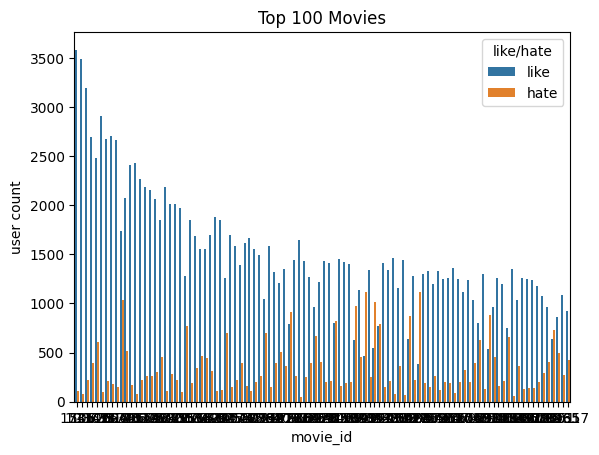

In [165]:
sns.barplot(data=data_df, x="movie_id", y="user count", hue="like/hate").set(title='Top 100 Movies')

In [126]:
movies_10

[3697,
 3569,
 3412,
 3092,
 3088,
 3008,
 2888,
 2886,
 2823,
 2772,
 2590,
 2584,
 2507,
 2487,
 2449,
 2420,
 2368,
 2311,
 2302,
 2294,
 2234,
 2067,
 2049,
 2040,
 2029,
 2029,
 2005,
 2005,
 1985,
 1966,
 1959,
 1847,
 1804,
 1794,
 1781,
 1767,
 1758,
 1754,
 1741,
 1737,
 1716,
 1715,
 1710,
 1705,
 1697,
 1693,
 1677,
 1663,
 1634,
 1629,
 1628,
 1622,
 1622,
 1617,
 1608,
 1607,
 1600,
 1593,
 1589,
 1589,
 1560,
 1559,
 1552,
 1551,
 1542,
 1519,
 1508,
 1505,
 1502,
 1501,
 1496,
 1483,
 1457,
 1457,
 1456,
 1448,
 1448,
 1442,
 1440,
 1439,
 1433,
 1425,
 1423,
 1421,
 1418,
 1415,
 1406,
 1405,
 1402,
 1391,
 1388,
 1387,
 1378,
 1377,
 1372,
 1369,
 1362,
 1356,
 1353,
 1345,
 1342,
 1341,
 1328,
 1321,
 1299,
 1294,
 1293,
 1290,
 1289,
 1288,
 1284,
 1279,
 1276,
 1268,
 1267,
 1264,
 1259,
 1258,
 1247,
 1243,
 1237,
 1235,
 1214,
 1213,
 1203,
 1199,
 1195,
 1195,
 1191,
 1190,
 1184,
 1184,
 1183,
 1178,
 1173,
 1171,
 1169,
 1167,
 1162,
 1161,
 1159,
 1152,
 1149,

,number of movies rate
count,1268.000000
mean,605.820978
std,470.135283
min,211.000000
25%,298.000000
50%,445.000000
75%,730.000000
max,3697.000000


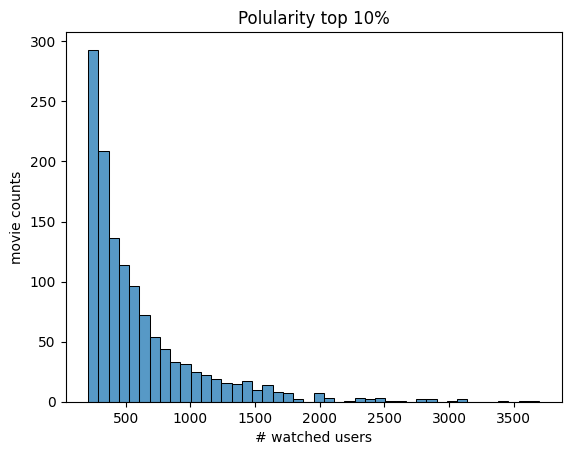

In [122]:
sns.histplot(movies_10).set(xlabel='# watched users', ylabel='movie counts', title='Polularity top 10%')
df = pd.DataFrame(movies_10, columns=['number of movies rate'])
df.describe()

,number of movies rate
count,12677.000000
mean,84.268991
std,232.144322
min,1.000000
25%,2.000000
50%,9.000000
75%,54.000000
max,3697.000000


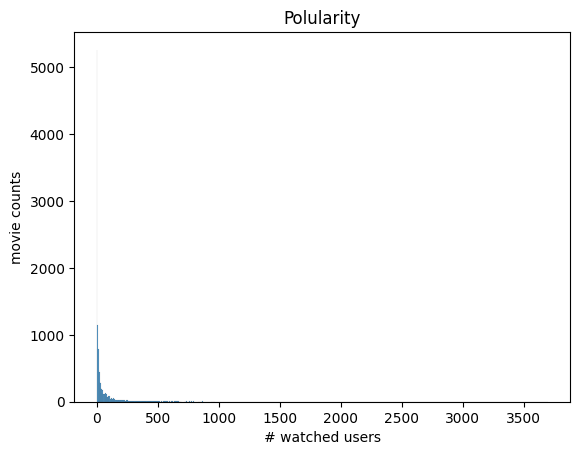

In [110]:
import seaborn as sns 
import pandas as pd

sns.histplot(movies).set(xlabel='# watched users', ylabel='movie counts', title='Polularity')
df = pd.DataFrame(movies, columns=['number of movies rate'])
df.describe()

,popularity (#likes)
count,12677.000000
mean,55.176225
std,182.751990
min,0.000000
25%,1.000000
50%,5.000000
75%,28.000000
max,3588.000000


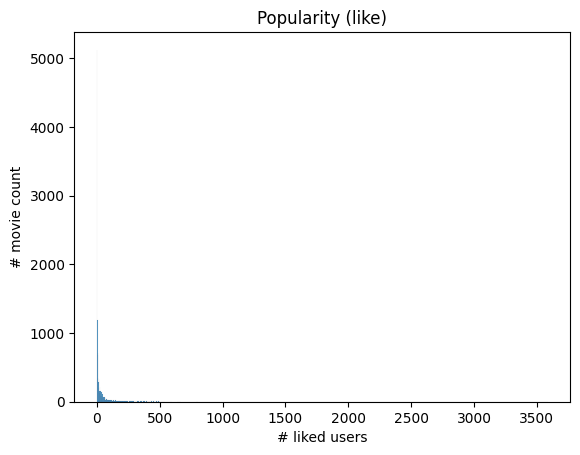

In [111]:
import seaborn as sns 
import pandas as pd

sns.histplot(movies_liked).set(xlabel='# liked users', ylabel='# movie count', title='Popularity (like)')
df = pd.DataFrame(movies_liked, columns=['popularity (#likes)'])
df.describe()

,popularity (#hates)
count,12677.000000
mean,29.092766
std,76.059544
min,0.000000
25%,1.000000
50%,3.000000
75%,19.000000
max,1121.000000


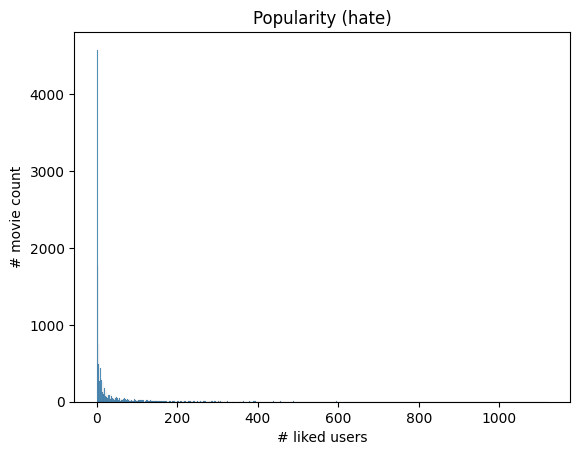

In [113]:
import seaborn as sns 
import pandas as pd

sns.histplot(movies_hated).set(xlabel='# liked users', ylabel='# movie count', title='Popularity (hate)')
df = pd.DataFrame(movies_hated, columns=['popularity (#hates)'])
df.describe()

In [9]:
diff = []
for user in used:
    likes = user_movie_liked[user]
    hates = user_movie_hated[user]

    avg_like = []
    for l in likes:
        l_copy = likes.copy()
        l_copy.remove(l)
        avg_like.append(pairwise_euclid(l, l_copy))

    # print(sum(avg_like) / len(avg_like))

    avg_hate = []
    for l in likes:
        avg_hate.append(pairwise_euclid(l, hates))
    
    # print(sum(avg_hate) / len(avg_hate))
    diff.append( sum(avg_hate) / len(avg_hate) - sum(avg_like) / len(avg_like) )
    

NameError: name 'pairwise_euclid' is not defined

,Diff
count,7317.000000
mean,0.103062
std,0.172945
min,-1.145514
25%,0.019210
50%,0.081983
75%,0.166723
max,1.849879


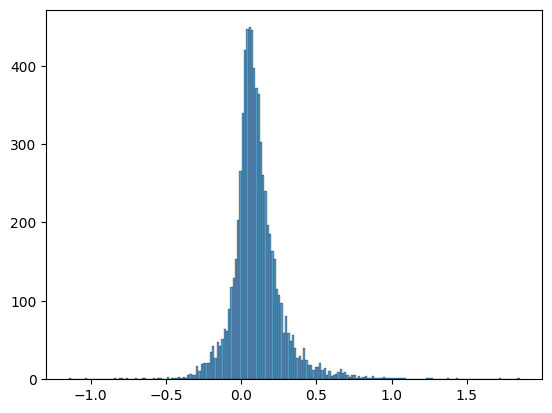

In [122]:
import seaborn as sns 
import pandas as pd

sns.histplot(diff).set(xlabel='', ylabel='', title='')
df = pd.DataFrame(diff, columns=['Diff'])
df.describe()

,Diff
count,500.000000
mean,0.080315
std,0.107045
min,-0.809485
25%,0.021774
50%,0.064324
75%,0.127835
max,0.682476


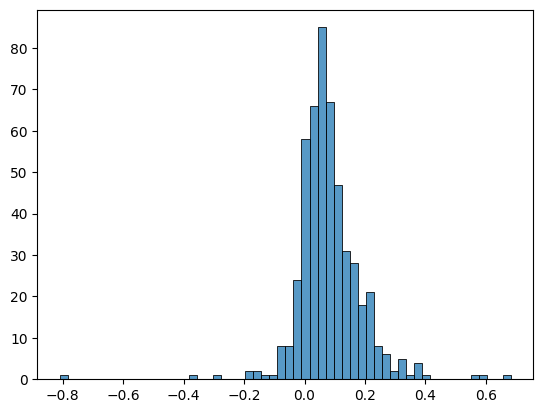

In [ ]:
import seaborn as sns 
import pandas as pd

sns.histplot(diff).set(xlabel='', ylabel='', title='')
df = pd.DataFrame(diff, columns=['Diff'])
df.describe()

In [107]:
diff

[0.05722507242807717,
 0.028878280905189957,
 0.05050777792086336,
 0.04376111244034098,
 0.10286983181841425,
 0.03170826420873096,
 0.09064743396786712,
 0.0011327060498875774,
 0.04447533880323773,
 0.021063526036613656]

In [90]:
l

'433'

In [38]:
user_movie_hated['9219']

['8', '12397', '12649']

In [43]:
user_movie_liked['9219']

['167', '8072']

In [66]:
cosines = []
for i in range(len(user_movie_liked['9219'])-1):
    for j in range(i+1, len(user_movie_liked['9219'])):
        cosines.append(euclidean(movie_embedding[user_movie_liked['9219'][i]], movie_embedding[user_movie_liked['9219'][j]]))

In [77]:
pairwise_euclid(user_movie_liked['9219'][0], [user_movie_liked['9219'][1]] )

1.6811192126148087

In [79]:
pairwise_euclid(user_movie_liked['9219'][0], user_movie_hated['9219'] )

1.930967538925411

In [80]:
pairwise_euclid(user_movie_liked['9219'][1], user_movie_hated['9219'] )

1.576824854385021

In [81]:
(1.930967538925411 + 1.576824854385021) / 2

1.753896196655216

In [65]:
sum(cosines) / len(cosines)

1.6602186220877193